## Test on a simple case
Consider the following Poisson Equation
$$
\begin{cases}
    \Delta u = 0\qquad &u\in\Omega\\
    u = xy\qquad &u\in\partial\Omega.
\end{cases}$$
Here $\Omega = \{(x, y)|\ 0< x, y< 1\}$

The exact solution to this problem is $$u = xy.$$

In [1]:
% matplotlib inline
import torch 
import torch.nn.functional as F
#learning rate decay
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
from math import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm

torch.set_default_tensor_type('torch.FloatTensor')

class DeepRitzNet(torch.nn.Module):
    def __init__(self, m):
        super(DeepRitzNet, self).__init__()
        self.linear1 = torch.nn.Linear(m,m)
        self.linear2 = torch.nn.Linear(m,m)
        self.linear3 = torch.nn.Linear(m,m)
        self.linear4 = torch.nn.Linear(m,m)
        self.linear5 = torch.nn.Linear(m,m)
        self.linear6 = torch.nn.Linear(m,m)
        self.linear7 = torch.nn.Linear(m,m)
        self.linear8 = torch.nn.Linear(m,m)
        
        self.linear9 = torch.nn.Linear(m,1)
        
        torch.nn.init.constant_(self.linear1.bias, 0.)
        torch.nn.init.constant_(self.linear2.bias, 0.)
        torch.nn.init.constant_(self.linear3.bias, 0.)
        torch.nn.init.constant_(self.linear4.bias, 0.)
        torch.nn.init.constant_(self.linear5.bias, 0.)
        torch.nn.init.constant_(self.linear6.bias, 0.)
        torch.nn.init.constant_(self.linear7.bias, 0.)
        torch.nn.init.constant_(self.linear8.bias, 0.)
        torch.nn.init.constant_(self.linear9.bias, 0.)
        
        torch.nn.init.normal_(self.linear1.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear2.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear3.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear4.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear5.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear6.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear7.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear8.weight, mean=0, std=0.1)
        torch.nn.init.normal_(self.linear9.weight, mean=0, std=0.1)
        
        
        '''
        torch.nn.init.xavier_uniform_(self.linear1.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear2.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear3.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear4.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear5.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear6.weight, gain=torch.nn.init.calculate_gain('relu'))
        torch.nn.init.xavier_uniform_(self.linear7.weight, gain=torch.nn.init.calculate_gain('relu'))
        '''
    def forward(self, x):
        y = x
        y = y + F.relu(self.linear2(F.relu(self.linear1(y))))
        y = y + F.relu(self.linear4(F.relu(self.linear3(y))))
        y = y + F.relu(self.linear6(F.relu(self.linear5(y))))
        y = y + F.relu(self.linear7(F.relu(self.linear8(y))))
        output = F.relu(self.linear9(y))
        return output

In [2]:
def cal_loss(mod):
    points = np.arange(0, 1.1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    mmm = 0
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() - U_groundtruth(re)
            mmm += abs(z[i, j])
            t += 1
    return mmm / t

In [3]:
#相对误差
#余冰的例子里面是
#print(np.linalg.norm(np.reshape(u_solve[:,0]-pu,[-1]),ord=2)/np.linalg.norm(np.reshape(pu,[-1]),ord=2))
def relative_err(mod):
    points = np.arange(0, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    w = np.zeros((xl, yl))
    t = 0
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)
            z[i, j] = mod(re.float()).item() - U_groundtruth(re)
            w[i, j] = U_groundtruth(re)
            t += 1
    z = z ** 2
    w = w ** 2
    return np.sum(z) / np.sum(w)

In [4]:
#U_groundtruth = x * y
#take in a (m,) tensor (x, y, ...)
def U_groundtruth(t):
    return (t[0] * t[1]).item()

In [5]:
def validate(mod):
    draw_graph(mod)
    print(cal_loss(mod))

In [6]:
def draw_graph(mod):
    points = np.arange(0, 1, 0.01)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()
    z = np.zeros((xl, yl))
    for i in range(xl):
        for j in range(yl):      
            re = np.zeros(m)
            re[0] = xs[i, j]
            re[1] = ys[i, j]
            re = torch.tensor(re)        
            z[i, j] = mod(re.float()).item() - U_groundtruth(re)
    
    plt.imshow(z, cmap=cm.hot)
    plt.colorbar()
    
    my_x_ticks = np.arange(0, 1, 0.2)
    my_y_ticks = np.arange(0, 1, 0.2)
    ax = plt.gca()
    ax.set_xticks(np.linspace(0,99,5))  
    ax.set_xticklabels(('0', '0.25', '0.5', '0.75', '1'))  
    ax.set_yticks(np.linspace(0,99,5))  
    ax.set_yticklabels( ('1', '0.75', '0.5', '0.25', '0'))  
    
    #plt.savefig("../Adaptive/loss_1.eps")
    
    plt.savefig("loss_yubing_2blocks.eps")
    plt.show()

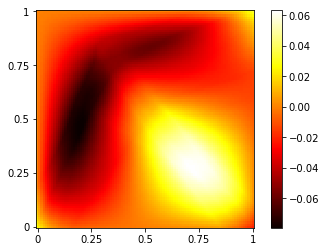

0.024103393883498244


In [20]:
validate(model)

In [19]:
relative_err(model)

0.01488313088178713

In [22]:
#only save the parameters
PATH = 'test_parameters.pkl'
torch.save(model.state_dict(), PATH)

In [9]:
m = 10
PATH = 'test_parameters.pkl'
#从文件读取the_model
model = DeepRitzNet(m)
model.load_state_dict(torch.load(PATH))

In [12]:
model = DeepRitzNet(m)

In [ ]:
#训练the_model
train(model, opt='Adam', iterations=50000, milestones=[10000,20000,30000,40000], gamma=0.5, beta=500, 
      beta_increase=1.01, alpha=0, alpha_increase=1, initial_lr=0.00001, print_every_iter=5)

In [7]:
m = 10
learning_rate = 0.01
iterations = 400  #default 10000
print_every_iter = 100
beta = 500 #coefficient for the regularization term in the loss expression, is set to be 1000 in section 3.1
#n1 = 1000 #number of points in (0,1)^m
n2 = 100  #number of points on the border of (0,1)^m
n3 = 100  #number of points used for evaluating the error
gamma = 10

In [8]:
# Calculate time for grid method
def train(mod, opt, initial_lr=learning_rate, n2=n2, milestones=[400], gamma=0.5, alpha=1, alpha_increase=1.01, 
          iterations=iterations, beta=1, beta_increase=1.01, print_every_iter=print_every_iter):
    if opt == 'Adam':
        optimizer = torch.optim.Adam(mod.parameters(), lr=initial_lr)
    elif opt == 'SGD':
        optimizer = torch.optim.SGD(mod.parameters(), lr=initial_lr)
    scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

    mm = 1
    points = np.arange(0, 1, 0.1)
    xs, ys = np.meshgrid(points, points)
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    xl, yl = xs.size()

    #start = time.time()
    for k in range(iterations):
        n1 = 0
        loss = torch.zeros(1)
        for i in range(xl):
            for j in range(yl):        
                x_input = np.zeros(m)
                x_input[0] = xs[i, j]
                x_input[1] = ys[i, j]
                
                n1 += 1
                x_input = torch.tensor(x_input).float()
                y = mod(x_input)

                x1 = torch.zeros(m)
                x2 = torch.zeros(m)
                x1[0] = 0.0001
                x2[1] = 0.0001
                x_input_1 = x_input.float() + x1
                x_input_2 = x_input.float() + x2
                x_input_3 = x_input.float() - x1
                x_input_4 = x_input.float() - x2
                x_input_grad_1 = (mod(x_input_1) - y) / 0.0001
                x_input_grad_2 = (mod(x_input_2) - y) / 0.0001
                x_input_2_grad_x = (mod(x_input_1) + mod(x_input_3) - 2 * y) / 0.0001**2
                x_input_2_grad_y = (mod(x_input_2) + mod(x_input_4) - 2 * y) / 0.0001**2

                loss += 0.5 * ((x_input_grad_1) ** 2 + (x_input_grad_2) ** 2)  \
                        + alpha * (x_input_2_grad_x + x_input_2_grad_y) ** 2
                #loss += 0.5 * ((x_input.grad.float()[0]) ** 2 + (x_input.grad.float()[1]) ** 2) + y
                #loss += alpha * (x_input_2_grad_x + x_input_2_grad_y) ** 2
        loss /= n1

        regularization = torch.zeros(1)
        for t in range(n2):
            x_input = np.zeros(m)
            x_input[0] = np.random.rand()
            x_input[1] = np.random.rand()
            x_rand = np.random.rand()
            if x_rand < 0.25:
                x_input[0] = 0
            elif x_rand > 0.25 and x_rand < 0.5:
                x_input[0] = 1
            elif x_rand > 0.5 and x_rand < 0.75:
                x_input[1] = 0
            elif x_rand > 0.75 :
                x_input[1] = 1
            x_input = torch.tensor(x_input).float()
            y = mod(x_input)
            regularization += (y - x_input[0] * x_input[1])**2 
        regularization *= beta / n2
        if alpha < 500:
            alpha *= alpha_increase
        if beta < 500:
            beta *= beta_increase
        
        if((k + 1) % print_every_iter == 0):
            #print loss
            print(k, " epoch, loss: ", loss.data[0].numpy())
            print(k, " epoch, regularization loss: ", regularization.data[0].numpy())
            print(k, " loss to real solution: ", cal_loss(mod))
        if cal_loss(mod) < 0.0001:
            break

        loss += regularization

        #and step the optimizer
        optimizer.zero_grad()
        loss.backward()

        scheduler.step()
        optimizer.step()
    #stop = time.time()
    #print(stop - start)